# This notebook is a test bench for working on the core model

In [1]:
import torch
import numpy as np
from torch import nn

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils.extmath import row_norms

from tqdm import tqdm
from copy import deepcopy
from dataclasses import dataclass
from typing import List, Dict

from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import gc

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [4]:
def lp_distance(X, Y, p=2):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [5]:
def cosine_distance(X, Y):
    """
    Computes the rowwise cosine distance between matrices X and Y.
    """
    dots = torch.stack([torch.dot(xi, yi) for xi, yi in zip(X, Y)])
    norms = torch.stack([torch.dot(xi.unsqueeze(0), yi.unsqueeze(0)) for xi, yi in zip(torch.norm(X, dim=1), torch.norm(Y, dim=1))])
    cos_sim = torch.div(dots, norms)
    return 1.0 - cos_sim

In [6]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [7]:
def mean_sparsity(X):
    """
    Computes the mean of the row-wise sparsity of the input feature-matrix X
    """
    return np.mean(np.count_nonzero(X, axis=1) / X.shape[1])

In [8]:
from dataclasses import dataclass
from transformers.file_utils import ModelOutput

@dataclass
class ClusterOutput(ModelOutput):
    
    loss: torch.FloatTensor = None
    predicted_labels: torch.IntTensor = None
    embeddings: torch.FloatTensor = None

In [9]:
def cls_embedding_extractor(model_output: ModelOutput):
    return model_output.last_hidden_state[:, 0, :].float()

def meanpooler_embedding_extractor(model_ouput: ModelOutput):
    return model_ouput.last_hidden_state.mean(dim=1).float()

def concat_cls_n_hidden_states(model_output: ModelOutput, n=3):
    n_hidden_states = model_output.hidden_states[-n:]
    return torch.cat([t[:, 0, :] for t in n_hidden_states], 1).float()

def concat_mean_n_hidden_states(model_output: ModelOutput, n=3):
    n_hidden_states = model_output.hidden_states[-n:]    
    return torch.cat([t.mean(dim=1) for t in n_hidden_states], 1).float()

class LearnableWeightedAverage(nn.Module):
    
    def __init__(self, n=3, device='cuda:0'):
        super(LearnableWeightedAverage, self).__init__()
        self.n = n
        self.device = device
        self.register_parameter(
            'weights',
            nn.Parameter(torch.ones(self.n).float().unsqueeze(1), requires_grad=True)
        )

        self.to(self.device)
    
    def __forward__(self, model_output: ModelOutput):
        n_hidden_states = model_output.hidden_states[-self.n:]
        #stacked_cls = torch.cat([t.mean(dim=1) for t in n_hidden_states], 0).reshape(-1, self.n, 768)
        stacked_cls = torch.cat([t[:,0,:] for t in n_hidden_states], 0).reshape(-1, self.n, 768)
        #return (stacked_cls * self.weights).mean(dim=1)
        return (stacked_cls * self.weights).reshape(stacked_cls.size()[0], -1)
    
    def __call__(self, *args, **kwargs):
        return self.__forward__(*args, **kwargs)
            

In [10]:
class ClusterLM(nn.Module):

    def __init__(self,
                 initial_centroids: torch.tensor,
                 lm_model,
                 tokenizer,
                 metric=lp_distance,
                 embedding_extractor=cls_embedding_extractor,
                 do_language_modeling=True,
                 device='cpu'
                 ):
        super(ClusterLM, self).__init__()

        self.initial_centroids = initial_centroids

        self.add_module('lm_model', lm_model)
        self.register_parameter('centroids', nn.Parameter(initial_centroids.clone().float(), requires_grad=True))

        self.tokenizer = tokenizer
        self.metric = metric
        self.embedding_extractor = embedding_extractor
        self.do_language_modeling = do_language_modeling
        self.device = device

        self.to(self.device)

    def forward(self, texts, alpha=1.0):
        """
        Input: texts and labels (optional)
        Returns: lm_language modelling output, own output dict (clustering_loss, predicted_labels)
        """
        # Language Modeling Part:

        lm_outputs = ModelOutput(loss=torch.tensor(0.0, requires_grad=True).to(self.device))

        if self.do_language_modeling:
            inputs = self.tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True)

            input_ids = inputs['input_ids'].clone()
            input_ids, true_ids = mask_tokens(input_ids, self.tokenizer)
            inputs['input_ids'] = input_ids

            inputs = inputs.to(self.device)
            true_ids = true_ids.to(self.device)
            lm_outputs = self.lm_model(labels=true_ids, **inputs)

        # Clustering Part:
        inputs = self.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True)

        inputs.to(self.device)

        # 0. Obtain embeddings for each input
        input_embeddings = self.embedding_extractor(self.lm_model.base_model(**inputs))
        
        # 1. Compute distances from each input embedding to each centroids
        distances = torch.stack([self.metric(embedding.unsqueeze(0), self.centroids) for embedding in input_embeddings])
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)  # => shape (n_centroids, n_samples)

        # 2. Compute the paramterized softmin for each centroid of each distance to each centroid per input sample
        # Find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        # Compute exponetials
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        # Compute softmin
        softmin = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. Weight the distance between each sample and each centroid
        weighted_distances = distances * softmin

        # 4. Sum over weighted_distances to obtain loss
        clustering_loss = weighted_distances.sum(dim=1).mean()

        # Create clustering output dictionary
        cluster_outputs = ClusterOutput(
            loss=clustering_loss,
            predicted_labels=nearest_centroids.long(),
            embeddings=input_embeddings.cpu().detach()
        )

        return lm_outputs, cluster_outputs


In [11]:
def init_model(
    lm_model,
    tokenizer,
    data_loader,
    n_clusters,
    embedding_extractor=concat_cls_n_hidden_states,
    device='cpu',
    random_state=np.random.RandomState(42),
    **kwargs,
):
    
    initial_embeddings = []
    for batch_texts, _ in data_loader:
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
        inputs = inputs.to(device)
        outputs = lm_model.base_model(**inputs)
        extracted_embeddings = embedding_extractor(outputs).cpu().detach().numpy()
        initial_embeddings.append(extracted_embeddings)
        
    initial_embeddings = np.vstack(initial_embeddings)
    
    
    initial_centroids = _k_init(
        initial_embeddings,
        n_clusters=np.unique(labels).shape[0],
        x_squared_norms=row_norms(initial_embeddings, squared=True),
        random_state=np.random.RandomState(42)
    )
    
    model = ClusterLM(
        lm_model=lm_model,
        tokenizer=tokenizer,
        embedding_extractor=embedding_extractor,
        initial_centroids=torch.from_numpy(initial_centroids),
        device=device,
        **kwargs
    )
    
    return model, initial_centroids, initial_embeddings

In [12]:
def evaluate(model, eval_data_loader, verbose=True):
    model.eval()
    true_labels = []
    predicted_labels = []
    eval_data_it = tqdm(eval_data_loader, desc='Eval') if verbose else eval_data_loader
    for batch_texts, batch_labels in eval_data_it:
        true_labels.extend(batch_labels.numpy().astype('int'))
        _, cluster_outputs = model(texts=list(batch_texts))
        predicted_labels.extend(cluster_outputs.predicted_labels.numpy().astype('int'))
    
    return np.array(predicted_labels), np.array(true_labels)

In [13]:
@dataclass
class TrainHistory:
    clustering_losses: List[float] 
    lm_losses: List[float]
    combined_losses: List[float]
    prediction_history: List[np.array]
    eval_hist: List[Dict[str, float]]
    

In [14]:
def train(
    n_epochs,
    model,
    optimizer,
    scheduler,
    annealing_alphas,
    train_data_loader,
    eval_data_loader=None,
    do_eval=True,
    clustering_loss_weight=0.5,
    metrics=(cluster_accuracy, adjusted_rand_score, normalized_mutual_info_score),
    verbose=True
):
    
    total_clustering_losses = []
    total_lm_losses = []
    total_combined_losses = []
    prediction_history = []
    eval_hist = []
    
    assert len(annealing_alphas) >= n_epochs
    for epoch, alpha in zip(range(n_epochs), annealing_alphas):
        model.train()
        train_data_it = tqdm(train_data_loader, desc='Train') if verbose else train_data_loader
        for batch_texts, _ in train_data_it:
            lm_outputs, cluster_outputs = model(texts=list(batch_texts), alpha=alpha)
            combined_loss = lm_outputs.loss + (clustering_loss_weight * cluster_outputs.loss)
            
        
            optimizer.zero_grad()
            combined_loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_clustering_losses.append(cluster_outputs.loss.item())
            total_lm_losses.append(lm_outputs.loss.item())
            total_combined_losses.append(combined_loss.item())
            
            if verbose:
                train_data_it.set_description(
                    f'Epoch: {epoch} | CombLoss: {combined_loss.item()} |LMLoss: {lm_outputs.loss.item()} | ' \
                    f' ClusterLoss: {cluster_outputs.loss.item()} | LR: {scheduler.get_last_lr()[0]} | Alpha: {alpha}'
                )
            
            
        if do_eval:
            if eval_data_loader is None:
                eval_data_loader = train_data_it if not verbose else train_data_it.iterable
            
            predicted_labels, true_labels = evaluate(
                model=model,
                eval_data_loader=eval_data_loader,
                verbose=verbose)
            
            prediction_history.append(deepcopy(predicted_labels))
            
            m = {}
            for metric in metrics:
                value = metric(true_labels, predicted_labels)
                m[metric.__name__] = value
                print(f'{metric.__name__}: {value}')
            eval_hist.append(m)
    
    train_history = TrainHistory(
        clustering_losses=total_clustering_losses,
        lm_losses=total_lm_losses,
        combined_losses=total_combined_losses,
        prediction_history=prediction_history,
        eval_hist=eval_hist
    )
    return train_history    

In [15]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [16]:
# Test params 
N_EPOCHS = 8
DEVICE = 'cuda:0'

EMBEDDING_EXTRACTOR = LearnableWeightedAverage()

In [17]:
import pandas as pd
df = pd.read_csv('datasets/ag_news_subset5.csv')

texts = df['texts'].to_numpy()
labels = df['labels'].to_numpy()

In [18]:
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('ag_news_subset', split='train', shuffle_files=True)
#test_ds = tfds.load('ag_news_subset', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['description'], example['label']
#        texts.append(text.decode("utf-8"))
#        labels.append(label)
#
#labels = np.array(labels)
#
#del train_ds
#del test_ds

In [19]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, stratify=labels, test_size=0.95, random_state=42)

In [20]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=8, shuffle=False) # batch size bigger => results better
# 16 for distilbert | 8 for bert-base

In [21]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from transformers import ElectraTokenizer, ElectraForMaskedLM
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import XLNetTokenizer, XLNetLMHeadModel

import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True, output_hidden_states=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', return_dict=True, output_hidden_states=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', return_dict=True, output_hidden_states=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-large-uncased', return_dict=True, output_hidden_states=True)

#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', return_dict=True, output_hidden_states=True)
#lm_model = RobertaForMaskedLM.from_pretrained('roberta-base', return_dict=True, output_hidden_states=True)

#tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', return_dict=True, output_hidden_states=True)
#lm_model = ElectraForMaskedLM.from_pretrained('google/electra-base-discriminator', return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("distilroberta-base", return_dict=True, output_hidden_states=True)


#tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", return_dict=True, output_hidden_states=True)
#lm_model = XLNetLMHeadModel.from_pretrained("xlnet-base-cased", return_dict=True, mem_len=1024, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/distilbert-base-uncased-STS-B", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/distilbert-base-uncased-STS-B", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-cased-STS-B", return_dict=True, output_hidden_states=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/bert-base-cased-STS-B", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-ag-news")
#lm_model = AutoModelForMaskedLM.from_pretrained("textattack/bert-base-uncased-ag-news", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("allenai/news_roberta_base")
#lm_model = AutoModelForMaskedLM.from_pretrained("allenai/news_roberta_base", return_dict=True, output_hidden_states=True)

#tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")
#lm_model = AutoModelForMaskedLM.from_pretrained("prajjwal1/bert-small", return_dict=True, output_hidden_states=True)


lm_model.to(DEVICE)

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [22]:
constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
alphas = np.zeros(N_EPOCHS, dtype=float)
alphas[0] = 0.1
for i in range(1, N_EPOCHS):
    alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
annealing_alphas = alphas / constant_value
#annealing_alphas = np.ones(N_EPOCHS) * 1000.0
annealing_alphas = np.arange(1, N_EPOCHS+1).astype('float')

In [23]:
model, initial_centroids, initial_embeddings = init_model(
    lm_model=lm_model,
    tokenizer=tokenizer,
    data_loader=data_loader,
    embedding_extractor=EMBEDDING_EXTRACTOR,
    n_clusters=np.unique(labels).shape[0],
    device=DEVICE
)

In [24]:
from tqdm import tqdm
import numpy as np
from transformers import (
    get_linear_schedule_with_warmup,
    get_constant_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup
)

# RMSprop
# or Adam(W)???
opt = torch.optim.RMSprop(
    params=model.parameters(),
    lr=2e-5, #2e-5, 5e-7, 
    eps=1e-8
)

total_steps = len(data_loader) * N_EPOCHS

#scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
#    optimizer=opt,
#    num_warmup_steps=int(len(data_loader)*0.5),
#    num_training_steps=total_steps,
#    num_cycles=N_EPOCHS//2
#)

scheduler = get_linear_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=int(len(data_loader)*0.5),
    num_training_steps=total_steps
)


In [25]:
hist = train(
    n_epochs=N_EPOCHS,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    annealing_alphas=annealing_alphas,
    train_data_loader=data_loader,
    clustering_loss_weight=1.0,
    verbose=True
)

Epoch: 0 | CombLoss: 12.908611297607422 |LMLoss: 2.653759717941284 |  ClusterLoss: 10.254851341247559 | LR: 1.866666666666667e-05 | Alpha: 1.0: 100%|██████████| 40/40 [00:03<00:00, 10.82it/s]  
Eval: 100%|██████████| 40/40 [00:01<00:00, 32.67it/s]
Epoch: 1 | CombLoss: 13.1847562789917 |LMLoss: 2.9845190048217773 |  ClusterLoss: 10.200237274169922 | LR: 1.8533333333333334e-05 | Alpha: 2.0:   5%|▌         | 2/40 [00:00<00:02, 12.68it/s]

cluster_accuracy: ({0: 2, 1: 3, 2: 0, 3: 1}, 0.2884012539184953)
adjusted_rand_score: -0.00434869321632866
normalized_mutual_info_score: 0.009616980279415457


Epoch: 1 | CombLoss: 12.529582977294922 |LMLoss: 2.665750741958618 |  ClusterLoss: 9.863832473754883 | LR: 1.6000000000000003e-05 | Alpha: 2.0: 100%|██████████| 40/40 [00:03<00:00, 11.57it/s]  
Eval: 100%|██████████| 40/40 [00:01<00:00, 33.79it/s]
Epoch: 2 | CombLoss: 12.324973106384277 |LMLoss: 2.5176541805267334 |  ClusterLoss: 9.807318687438965 | LR: 1.586666666666667e-05 | Alpha: 3.0:   5%|▌         | 2/40 [00:00<00:03, 11.95it/s]

cluster_accuracy: ({0: 2, 1: 3, 2: 0, 3: 1}, 0.2884012539184953)
adjusted_rand_score: -0.004435400549315661
normalized_mutual_info_score: 0.013903018400329507


Epoch: 2 | CombLoss: 13.447882652282715 |LMLoss: 3.626375436782837 |  ClusterLoss: 9.821507453918457 | LR: 1.3333333333333333e-05 | Alpha: 3.0: 100%|██████████| 40/40 [00:03<00:00, 10.40it/s] 
Eval: 100%|██████████| 40/40 [00:01<00:00, 32.92it/s]
Epoch: 3 | CombLoss: 12.019965171813965 |LMLoss: 2.3816802501678467 |  ClusterLoss: 9.638284683227539 | LR: 1.3200000000000002e-05 | Alpha: 4.0:   5%|▌         | 2/40 [00:00<00:03, 11.09it/s]

cluster_accuracy: ({0: 2, 1: 3, 2: 0, 3: 1}, 0.2884012539184953)
adjusted_rand_score: -0.004435400549315661
normalized_mutual_info_score: 0.013903018400329507


Epoch: 3 | CombLoss: 11.832050323486328 |LMLoss: 2.041098117828369 |  ClusterLoss: 9.790952682495117 | LR: 1.0666666666666667e-05 | Alpha: 4.0: 100%|██████████| 40/40 [00:03<00:00, 10.32it/s] 
Eval: 100%|██████████| 40/40 [00:01<00:00, 33.07it/s]
Epoch: 4 | CombLoss: 12.714618682861328 |LMLoss: 3.1311495304107666 |  ClusterLoss: 9.58346939086914 | LR: 1.0533333333333333e-05 | Alpha: 5.0:   5%|▌         | 2/40 [00:00<00:03, 10.81it/s]

cluster_accuracy: ({0: 2, 1: 3, 2: 0, 3: 1}, 0.2852664576802508)
adjusted_rand_score: -0.004830672625684801
normalized_mutual_info_score: 0.01245705139220826


Epoch: 4 | CombLoss: 11.759573936462402 |LMLoss: 2.2981479167938232 |  ClusterLoss: 9.46142578125 | LR: 8.000000000000001e-06 | Alpha: 5.0: 100%|██████████| 40/40 [00:03<00:00, 10.71it/s]    
Eval: 100%|██████████| 40/40 [00:01<00:00, 31.38it/s]
Epoch: 5 | CombLoss: 12.422208786010742 |LMLoss: 2.9589743614196777 |  ClusterLoss: 9.463233947753906 | LR: 7.866666666666667e-06 | Alpha: 6.0:   5%|▌         | 2/40 [00:00<00:03, 12.58it/s]

cluster_accuracy: ({0: 2, 1: 3, 2: 0, 3: 1}, 0.27899686520376177)
adjusted_rand_score: -0.005441219144728253
normalized_mutual_info_score: 0.01169453873579459


Epoch: 5 | CombLoss: 11.891063690185547 |LMLoss: 2.3387224674224854 |  ClusterLoss: 9.55234146118164 | LR: 5.333333333333334e-06 | Alpha: 6.0: 100%|██████████| 40/40 [00:03<00:00, 12.15it/s]  
Eval: 100%|██████████| 40/40 [00:01<00:00, 32.88it/s]
Epoch: 6 | CombLoss: 11.472437858581543 |LMLoss: 1.9742975234985352 |  ClusterLoss: 9.498140335083008 | LR: 5.2666666666666665e-06 | Alpha: 7.0:   2%|▎         | 1/40 [00:00<00:04,  9.24it/s]

cluster_accuracy: ({0: 2, 1: 1, 2: 0, 3: 3}, 0.2727272727272727)
adjusted_rand_score: -0.005873806392695181
normalized_mutual_info_score: 0.004745273485172255


Epoch: 6 | CombLoss: 11.690874099731445 |LMLoss: 2.365770101547241 |  ClusterLoss: 9.325103759765625 | LR: 2.666666666666667e-06 | Alpha: 7.0: 100%|██████████| 40/40 [00:03<00:00, 10.70it/s]  
Eval: 100%|██████████| 40/40 [00:01<00:00, 32.01it/s]
Epoch: 7 | CombLoss: 11.927657127380371 |LMLoss: 2.5445053577423096 |  ClusterLoss: 9.38315200805664 | LR: 2.5333333333333338e-06 | Alpha: 8.0:   5%|▌         | 2/40 [00:00<00:03, 11.00it/s]

cluster_accuracy: ({0: 2, 1: 0, 2: 3, 3: 1}, 0.27586206896551724)
adjusted_rand_score: -0.005450594474428986
normalized_mutual_info_score: 0.012275886102378116


Epoch: 7 | CombLoss: 11.500667572021484 |LMLoss: 2.117013454437256 |  ClusterLoss: 9.383654594421387 | LR: 0.0 | Alpha: 8.0: 100%|██████████| 40/40 [00:03<00:00, 10.70it/s]                    
Eval: 100%|██████████| 40/40 [00:01<00:00, 31.85it/s]

cluster_accuracy: ({0: 2, 1: 0, 2: 3, 3: 1}, 0.27586206896551724)
adjusted_rand_score: -0.005450594474428986
normalized_mutual_info_score: 0.012275886102378116


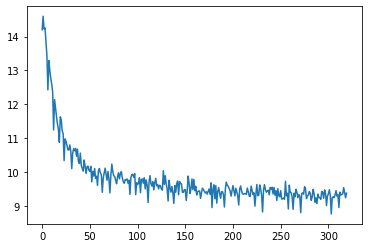

In [26]:
plt.plot(hist.clustering_losses)
plt.show()

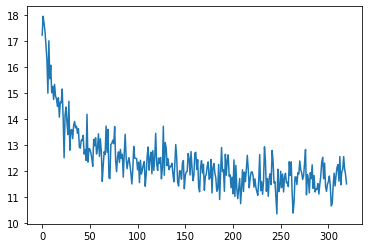

In [27]:
plt.plot(hist.combined_losses)
plt.show()

In [28]:
[i['cluster_accuracy'][0] for i in hist.eval_hist]

[{0: 2, 1: 3, 2: 0, 3: 1},
 {0: 2, 1: 3, 2: 0, 3: 1},
 {0: 2, 1: 3, 2: 0, 3: 1},
 {0: 2, 1: 3, 2: 0, 3: 1},
 {0: 2, 1: 3, 2: 0, 3: 1},
 {0: 2, 1: 1, 2: 0, 3: 3},
 {0: 2, 1: 0, 2: 3, 3: 1},
 {0: 2, 1: 0, 2: 3, 3: 1}]

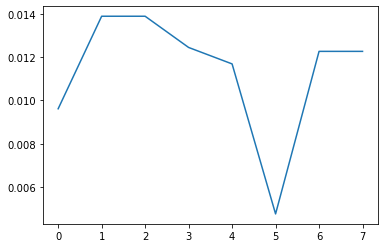

In [29]:
plt.plot([i['normalized_mutual_info_score'] for i in hist.eval_hist])
plt.show()

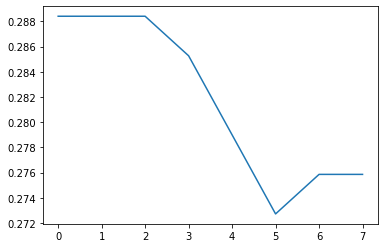

In [30]:
plt.plot([i['cluster_accuracy'][1] for i in hist.eval_hist])
plt.show()

In [31]:
import pickle
with open('train_results_test.h', 'wb') as f:
    pickle.dump(hist, file=f)

In [32]:
#del tokenizer
#del scheduler
#del opt
#del model

In [33]:
gc.collect()

11212

In [34]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [35]:
from transformers.file_utils import ModelOutput

In [36]:
torch.arange(4).reshape(2, 2) * torch.arange(2).unsqueeze(1)

tensor([[0, 0],
        [2, 3]])

In [37]:
x = torch.ones(24).reshape(6, 4).unsqueeze(0)
x1 = x.clone() * 2
x2 = x.clone() * 3
b = torch.cat([x, x1, x2], 0)
b.size()

torch.Size([3, 6, 4])

In [38]:
b

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.],
         [2., 2., 2., 2.]],

        [[3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [3., 3., 3., 3.],
         [3., 3., 3., 3.]]])

In [39]:
w = torch.arange(6).unsqueeze(1)
w

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5]])

In [40]:
(w * b).mean(dim=1).shape

torch.Size([3, 4])

In [41]:
b * w.T

RuntimeError: The size of tensor a (4) must match the size of tensor b (6) at non-singleton dimension 2

In [ ]:
w = torch.ones(2, requires_grad=True).float().unsqueeze(1).unsqueeze(1) * 3

In [ ]:
b * w

In [42]:
EMBEDDING_EXTRACTOR.weights

Parameter containing:
tensor([[0.9977],
        [0.9989],
        [0.9968]], device='cuda:0', requires_grad=True)

In [ ]:
model.centroids == initial_centroids

In [44]:
model.centroids.shape

torch.Size([4, 2304])